# BIODS220 Assignment 1 Part a: Diabetic Retinopathy

Diabetic retinopathy (DR) is an eye disease prevalent in diabetic patients. It is the leading cause of blindness in people aged 20-64. Screening for DR allows earlier and more effective treatment options, and accurate screening can save the eyesight of millions. A deep-learning approach to predicting DR from eye images was proposed in 2016, in the paper "Development and Validation of a Deep Learning Algorithm for Detection of Diabetic Retinopathy in Retinal Fundus Photographs", published in JAMA.

In this assignment we will use a similar dataset of retina images hosted by Kaggle. We'll train a model to predict whether or not to refer a patient for treatment given binarized severity of DR in patients: no referral if [No DR, mild] and referral if [moderate, severe, and proliferate DR].

## Section 1: Data

unzip diabetic-retinopathy-detection.zip "train*"Let's first explore the dataset, which is hosted by Kaggle. Go to https://www.kaggle.com/c/diabetic-retinopathy-detection/data, create a Kaggle account, then accept the competition rules after clicking the "Late Submission" button. 

In your working environment run ```pip install kaggle```.

Go to the ‘Account’ tab of your user profile and select ‘Create New API Token’. Your personal `kaggle.json` file, which contains your Kaggle username and key, will download. Copy in your username and key to the following lines and run it in your Terminal to set these variables in your environment.

```export KAGGLE_USERNAME=your_user_name```

```export KAGGLE_KEY=your_key```


Downloading this dataset takes a while, so we recommend you use ```screen``` or ```tmux``` and do other tasks. Run the following in the directory where you want to put the data. 

```kaggle competitions download -c diabetic-retinopathy-detection``` (about 25 - 30 min)

```unzip diabetic-retinopathy-detection.zip "train*"``` (~25 min)

```rm diabetic-retinopathy-detection.zip  #``` Do this **after** running the unzip command.

```cat train.zip.* > train.zip``` (~20 min)

```unzip train.zip``` (~15 min)

```unzip trainLabels.csv.zip``` (~1 min)

You'll now have a directory called `train/` with the images we'll use for this notebook.

If `cv2` is not installed, you can install it with the command `pip install opencv-python`.


**Q1a.1**: Read over the data descriptions from Kaggle. Write down the source of data and list the the two ways that images are shown.

Source of the data:
The data consists of a large set of high-resolution retina images taken under a variety of imaging conditions. 

Two ways the images are shown:
1) Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1)

2) A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
    0 - No DR
    1 - Mild
    2 - Moderate
    3 - Severe
    4 - Proliferative DR


Import the necessary libraries and set our path by running the cell below. Replace IMAGE_PATH with the path to the `train` directory with all the images. Replace LABEL_PATH with the path to `trainLabels.csv`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from sklearn.metrics import roc_curve

random.seed(2) # don't change this

# FILL IN CODE HERE #

IMAGE_PATH = "/home/jupyter/train/"
LABEL_PATH = "~/trainLabels.csv"

# FILL IN CODE HERE #

Before beginning the data processing, let's first analyze the composition of our dataset.

**Q1a.2**: There are five classes: No DR (0), mild (1), moderate (2), severe (3), and proliferate DR (4). Graph a histogram for the classes. Write down the percentage of the largest class in the written answer below. 

Hints: use a pandas DataFrame to read the labels data. To create the histogram, you can either use pandas, or a combination of numpy and matplotlib.

73.5% is the largest class which is class zero. 

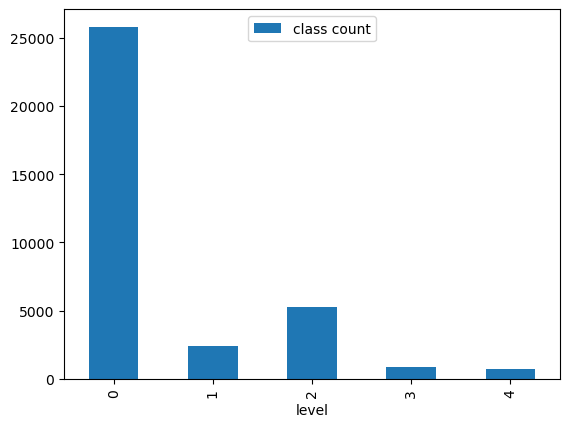

In [2]:
df = pd.read_csv(LABEL_PATH)
levels = df.groupby(['level']).agg('count').reset_index()
levels.plot.bar(x = 'level', y = 'image');
plt.legend(('class count',),loc='upper center');

**Q1a.3**: As you can see from the histogram, our dataset is very imbalanced. Imbalanced datasets are common in healthcare, such as image datasets in ophthalmology and pathology. 

Give one reason why imbalanced datasets are common in health care, and suggest a problem that imbalanced data could cause. 

Imbalanced datasets are common in health care since we often encounter null cases. Thankfully, there are countless times when a patient gets something checked and everything comes back normal. Typically, severe diseases and conditions are often more rare events. For this reason, healthcare datasets often are unbalanced and have many more null and mild cases than severe. 

This could pose a problem with classification metrics. Say 99% of our data was null and 1% of our data was a case. Then, a classifier would do a very good job by predicting that everything is null (99% accuracy). We would not want this since our classifier would not be able to distinguish between cases and nulls, and would thus be useless. 



We want to use a deep learning model to refer patients to doctors based on the severity of risk seen in fundus photos. Therefore we will explore binary classification of 'no refer' and 'refer'. We will need binary labels, bucketing:
-  [No DR, mild] are 'no refer'
- [Moderate, Severe, Proliferate] are 'refer'. 

Because our dataset is imbalanced, we'll take 2000 random samples from 'no refer' class and 2000 random samples from 'refer' class. (This is the crudest method for dealing with imbalanced data, but it will be good enough to get decent results in this exercise). 

**Q1a.4**: DR levels [0, 1] will be 'no refer' and DR levels [2, 3, 4] will be 'refer'. Randomly sample 2000 from each type by creating 2 lists of image filenames: `no_refer_examples` and `refer_examples`. For example, refer_examples will consist of ['11503_right', '44093_right', etc], if these image names are DR levels 2, 3, or 4. 


In [ ]:
no_ref = df[df['level'] < 2].drop(['level'], axis = 1)
ref = df[df['level'] >= 2].drop(['level'], axis = 1)

no_refer_examples= list(no_ref.sample(2000).values.flatten())
refer_examples = list(ref.sample(2000).values.flatten())

**Q1a.5**: Complete the `load_data` function to generate a train/validation/test sets with split `(0.6,0.2,0.2)`.


Read in the images and labels to numpy arrays using Keras functions `load_img` and ```img_to_array```. (If you get a dependency error for `Pillow`, then just run `pip install Pillow` in the VM terminal.) For each image: 
- resize to ```IMAGE_SIZE``` using ```cv2``` with interpolation flag `cv2.INTER_LANCZOS4`
- normalize the pixels in each image with the max and min pixel value of that image (so each image will have min pixel value 0, and max pixel value 1.

The expected shapes of the output are:
- `X_train`  is`(2400, 224, 224, 3)`; `X_val` and `X_test`  is `(800, 224, 224, 3)`
- `y_train`  is `(2400,)`; `y_val` and `y_test`  is `(800,)`


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
IMAGE_SIZE = (224, 224)

def load_data(image_path, label_path, split=(0.6,0.2,0.2)):
    """
    Load batches of images and labels. Splits images and labels 
    into arrays 
    
    Parameters:
    IMAGE_PATH (str/path): path to directory with images.
    LABEL_PATH (str/path): path to directory with labels.
    split (tuple): 3 values summing to 1 defining split of train, validation and test 
    
    Returns:
    X_train (np.ndarray): Train images. A numpy array of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels. A numpy array of shape (N_train,)
    X_val (np.ndarray): Val images. A numpy array of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels. A numpy array of shape (N_val,)
    X_test (np.ndarray): Test images. A numpy array of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels. A numpy array of shape (N_test,)
    """
    train_images = []
    train_labels = []
    
    # FILL IN CODE HERE #
    # create lists of images and labels `train_images` and `train_labels`#
    total_images = no_refer_examples + refer_examples
    for img_id in total_images:
        image = img_to_array(load_img(image_path + str(img_id) + ".jpeg"))
        image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_LANCZOS4)
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        train_images.append(image)
        train_labels.append([0 if img_id in no_refer_examples else 1])
        

    # FILL IN CODE HERE #
    
    all_images = np.stack(train_images)
    all_labels = np.array(train_labels).flatten() 
    
    # FILL IN CODE HERE #
    # Split train/val/test by creating the returned variables # 
    X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.4)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

    # FILL IN CODE HERE #
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data(IMAGE_PATH, LABEL_PATH)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

This processing should take around 15 minutes to finish. 

We recommend saving the data to a file using the next cell. Once you've done that, comment out that cell. When you need to load this data again in the future, ybcommenting out the code in the cell after and run it.

In [ ]:
# # This method saves your data
"""saved_data_path='your_path_here' # change to your path
with open(saved_data_path, 'wb') as f:
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, X_val)
    np.save(f, y_val)
    np.save(f, X_test)
    np.save(f, y_test)"""

In [3]:

# This method loads your data
saved_data_path='your_path_here'
with open(saved_data_path, 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f)
    X_val = np.load(f)
    y_val = np.load(f)
    X_test = np.load(f)
    y_test = np.load(f)


Let's sanity check our load data function by printing out the first five training examples along with the label of each example as the title.

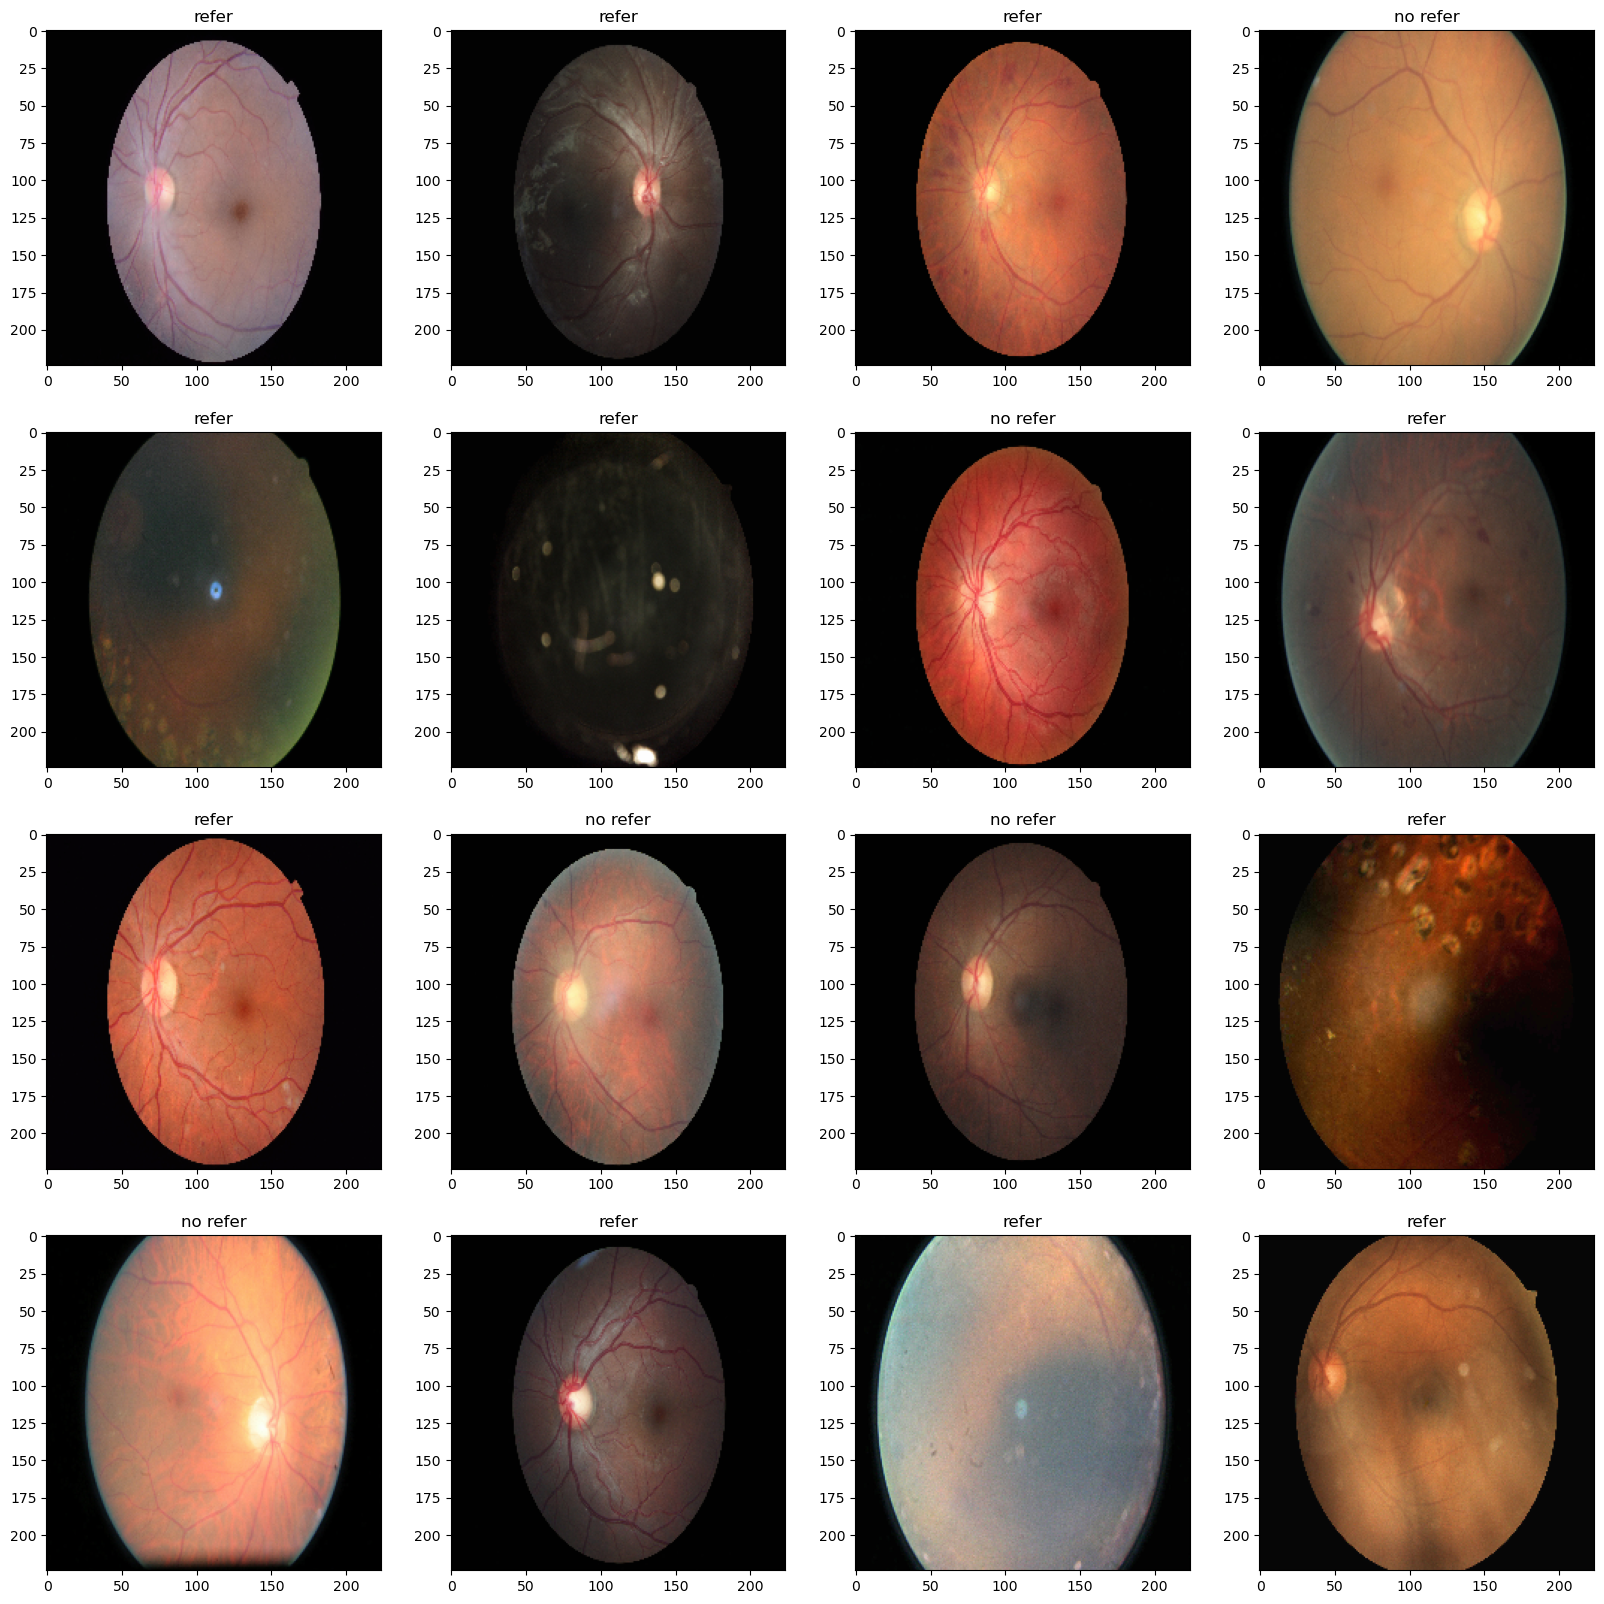

In [4]:
nrows, ncols = 4,4
f, axs = plt.subplots(nrows, ncols, figsize=(20,20))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(X_train[indx])
        axs[i,j].set(title=y_train[indx])

**Q1a.6**: We've split the input into train, validation, and test sets. We will now train the model with the train set, and use performance on the validation set to tune hyperparameters. Finally, we will evaluate on the test set.

Explain the purpose of the test set, and why we don't use it till the end of the analysis. 

The test set is meant to give you a final, unbiased performance measure of your model. Unlike the validation set, the test set gatekeeped until the very end of analysis. The validation set is used to optimize model hyperparameters. If we used the test set to do this, we would not have a completely unbiased estimate of our model performance since our test set is used for optimization (which is a part of the training process). This will give us a deceptive final estimate of performance which is overoptimistically biased. Thus, we save our test set until the very end so that we keep it independent and avoid these biases. 

Run the below cells to create train, validation, and test datasets from our preprocessed data.

In [5]:
y_train = [1 if i == 'refer' else 0 for i in y_train]
y_val = [1 if i == 'refer' else 0 for i in y_val]
y_test = [1 if i == 'refer' else 0 for i in y_test]

In [6]:
BATCH_SIZE = 10

train_dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


2022-10-17 23:20:41.092129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 23:20:41.192033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 23:20:41.193980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 23:20:41.197846: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Section 2: Model

**Q1a.7**: Let's create a model for DR using keras. We will be using a MobileNet (https://arxiv.org/abs/1704.04861) pre-trained on ImageNet as our base model and fine-tune it on our dataset. This is called transfer learning. MobileNet is a lightweight convolutional neural network structure. It achieves comparable accuracy to that of Inception and ResNet for most problems but is more efficient, requiring less memory and compute to train. 

First, specify ```tf.keras.applications.mobilenet_v2.MobileNetV2``` as our base_model (see the documentation for Keras saved models https://keras.io/api/applications/mobilenet/). Set `weights="imagenet"` and ```include_top=False``` because we want to remove the last layer (which has 1000 nodes corresponding to the 1000 ImageNet classes; we want to have only one output node for our binary classification task).

Use `tf.keras.Sequential` to add the following layers:
- `average_layer` by using a global average pooling layer from the Keras API. This aggregates the model outputs from the base layer. 
- One dense `prediction_layer`, so that our final layer is the right dimension for binary classification, with an `activation` layer that will force the input into the appropriate range for binary classification. 

Compile your model using the Keras commands and include:
- An appropriate loss function for binary classification.
- Use the `Adam` optimizer with initial learning rate 0.1. 
- Add the `accuracy` metric. 

In [7]:
# FILL IN CODE HERE #
input_shape = (224, 224, 3)

base_model=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')


model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()

metrics = ["accuracy"]
model.compile(optimizer, loss, metrics)

# FILL IN CODE HERE #

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


**Q1a.8**: Call ```model.fit``` (https://keras.io/models/model/) with 30 epochs on the train set and validate on the validation set. You should get poor performance for these current starter hyperparameters, so don't worry. This could be due to the choice of learning rate, choice of optimizer, or choice of loss function.

Tune the learning rate, and rerun ```model.fit``` to achieve better accuracy on the validation dataset. Set `input_shape` to the correct image size (with channels). You should be able to get above 0.9 accuracy for train and above 0.6 accuracy for validation. You may need to stop the model early if it shows signs of overfitting. Report your accuracies below.

In [9]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hist = model.fit(
    train_dset,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=val_dset,
    #callbacks=callback
)

Epoch 1/30


2022-10-17 23:20:56.919154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-17 23:20:58.794958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


240/240 [==============================] - 33s 76ms/step - loss: 0.6627 - accuracy: 0.6121 - val_loss: 1.4980 - val_accuracy: 0.4850
Epoch 2/30
240/240 [==============================] - 18s 74ms/step - loss: 0.2925 - accuracy: 0.8875 - val_loss: 1.8065 - val_accuracy: 0.5025
Epoch 3/30
240/240 [==============================] - 18s 76ms/step - loss: 0.1018 - accuracy: 0.9725 - val_loss: 3.9909 - val_accuracy: 0.5000
Epoch 4/30
240/240 [==============================] - 18s 75ms/step - loss: 0.1402 - accuracy: 0.9483 - val_loss: 3.1715 - val_accuracy: 0.5063
Epoch 5/30
240/240 [==============================] - 18s 76ms/step - loss: 0.1676 - accuracy: 0.9296 - val_loss: 3.6339 - val_accuracy: 0.5063
Epoch 6/30
240/240 [==============================] - 18s 76ms/step - loss: 0.1109 - accuracy: 0.9608 - val_loss: 5.0500 - val_accuracy: 0.4963
Epoch 7/30
240/240 [==============================] - 18s 77ms/step - loss: 0.0709 - accuracy: 0.9762 - val_loss: 3.0319 - val_accuracy: 0.5625
Epo

*Accuracy for train*: 1.0

*Accuracy for validation*: 0.72

**Q1a.9**: Tuning hyperparameters is crucial to deep learning! Explain the changes you made to tune the model, and suggest why it may have improved training. 

1. I decreased the learning rate to 1e-3. By decreasing the learning rate, we avoid undesirable divergent behavior in the loss function. If the learning rate is too high, we can skip the optimal solution. When we lower our learning rate, our weights change more slowly between iterations, and we are more likely to move towards the local minima at each progressive step. Thus, lowering our learning helps with model convergence. 


## Section 3: Evaluation

Evaluation is one of the most important parts of medical classification, as it helps us determine what to do with the model predictions and how they can improve screening processes. 

We've used the train and test set to create the model. Notice that (`X_test`, and `y_test`) were not used in that process. It would be very bad practice to evaluate the model on the test set, and then return and update the model based on those results (then the test set is acting like just another validation set). 

We'll explore different ways to assess our model in the next questions.

**Q1a.10**: The simplest evaluation is accuracy. Use ```model.evaluate``` (https://keras.io/models/model/) with ```X_test``` and ```y_test``` and print the test accuracy (this will work if you compiled the model with the accuracy metric earlier). You should have an accuracy of above 0.6.

In [10]:
# FILL IN CODE HERE #
score = model.evaluate(test_dset)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
# FILL IN CODE HERE #

80/80 [==============================] - 2s 16ms/step - loss: 1.7854 - accuracy: 0.6913
Test loss: 1.7853751182556152
Test accuracy: 0.6912500262260437


**Q1a.11**: Let's go deeper by considering the balance of false-positive and false-negative rates. Use `sklearn.metrics.roc_curve` to compute false-positive and true-positive rates at different levels of binary threshold. 
Plot the ROC curve, and then use `sklearn.metrics.roc_auc_score` to compute the AUC (area under the curve of the ROC curve). You should get an AUC greater than 0.7.

In the written answer below, interpret what the AUC means.


AUC score=0.7540314503205128


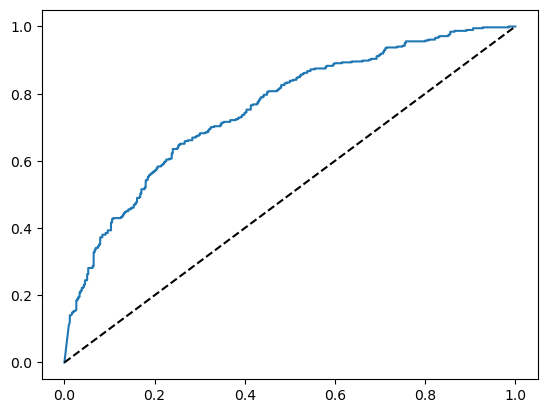

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
def check_binarized_auc(test_dset, model):
    """
    Given a trained model and test dataset, compute the parameters of the ROC curve
    and compute the AUC. 
    
    Parameters:
    test_dset (tf.data.Dataset): test dataset
    model (tf.keras.model): prediction model
    
    Returns: 
    fpr (np.ndarray): same as docstring of sklearn.metrics.roc_curve
    tpr (np.ndarray): same as docstring of sklearn.metrics.roc_curve
    thresholds (np.ndarray): same as docstring of sklearn.metrics.roc_curve
    auc (float): area under the ROC curve for the curve defined by fpr, tpr, and thresholds.
    """
    # FILL IN CODE HERE #
    scores = model.predict(test_dset)
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    
    # FILL IN CODE HERE #
    return fpr, tpr, thresholds, auc

fpr, tpr, thresholds, auc = check_binarized_auc(test_dset, model)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
print(f"AUC score={auc}")

AUC, Area under the ROC Curve (shown above), represents the degree of separability between two classes. It tells you how much the model is capable of distinguishing between binary classes as its discrimination threshold is varied. The higher the AUC, the better the model is at predicting 0 for class 0 and 1 for class 1 (or case for class case and control for class control).

**Q1a.12**: Finally, let's choose an operating point using Youden’s index (https://en.wikipedia.org/wiki/Youden%27s_J_statistic) and report the sensitivity and specificity at that point.

In [13]:
def choose_operating_point(fpr, tpr, thresholds):
    """
    Given ROC curve parameters, choose an operating point 
    using the Youden J statistic 
    
    Parameters: 
    fpr, tpr, thresholds (np.ndarray): same as docstring for `check_binarized_auc`
    
    Returns:
    op_point (float): operating point threshold for binary task chosen with Youdens J statistic
    sens (float): test dataset sensitivity score, https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    spec (float): test dataset specificity score, https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    """
    
    # FILL IN CODE HERE #
    neg = len(y_test) - sum(y_test)
    pos = sum(y_test)
    fn = (pos - tpr * pos)
    tn = (neg - fpr * neg)
    tp = tpr*pos
    fp = fpr*neg
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    youdens = sensitivity + specificity - 1
    max_index = np.argmax(youdens)
    op_point = thresholds[max_index]
    sens = sensitivity[max_index]
    spec = specificity[max_index]
    
    # FILL IN CODE HERE #
    return op_point, sens, spec

op_point, sens, spec = choose_operating_point(fpr, tpr, thresholds)
print(f'Operating point: {op_point}')
print(f'Sensitivity: {sens}')
print(f'Specificity: {spec}')

Operating point: 0.3873671591281891
Sensitivity: 0.6354166666666666
Specificity: 0.7596153846153846


**Q1a.13**: What does it mean to choose an operating point with high sensitivity, and an operating point with high specificity? List one medical application where high sensitivity is needed, and one when high specificity is needed.

An operating point with high sensitivity means that there are few false negative results at that threshold, and thus fewer cases are missed. An operating point with a high specificity means that there are very few false positives at that threshold, and thus fewer nulls are categorized incorrectly. 

In medicine, cancer detection would need high sensitivity. If someone who was cancer free was marked as a case, the doctor could run a few additional tests to determine that the test was incorrect. While this is an inconvenience for the patient, it is not life threatening. On the other hand, if someone with cancer was marked as cancer free, that could be a life threatening situation. 

In medicine, perscribing an agressive drug would need high specificity. If someone who was marked as a case actually did not have the disease, then perscribing an unecessary agressive drug would be detrimental for the patient. Thus, we would need to be very certain that the individual had the disease before giving them the drug. 